In [1]:
import os  
import tensorflow as tf  
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.preprocessing.image import img_to_array, load_img  
from tensorflow.keras.utils import to_categorical  
from sklearn.model_selection import train_test_split  
import numpy as np  
import matplotlib.pyplot as plt  
import math  
import shutil  
from tensorflow.keras.preprocessing import image  
from tensorflow.keras import layers, models  
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models  
from tensorflow.keras.optimizers import Adam  

# You might need to adjust this base_dir to your dataset structure  
base_dir = 'dataset/training'  
augmented_dir = 'dataset/augmented'  
test_dir = 'dataset/test'

classes = ['good', 'anomaly']  
batch_size = 16
# Clean up the augmented directory (optional)  
if os.path.exists(augmented_dir):  
    shutil.rmtree(augmented_dir)
    
os.makedirs(augmented_dir)
os.makedirs(f"{augmented_dir}/good")
os.makedirs(f"{augmented_dir}/anomaly")
  
# Image dimensions  
img_width, img_height = 96, 96  
# Setting the number of augmentations per image  
augmentations_per_image = 15  
  
# Initialize the image data generator for augmentation  
datagen = ImageDataGenerator(  
    rescale=1./255,  
    rotation_range=40,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2,  
    zoom_range=0.2,  
    horizontal_flip=True,  
    fill_mode='nearest'  
)  
  
def save_augmented_images(class_name):  
    image_dir = os.path.join(base_dir, class_name)
    images = [img for img in os.listdir(image_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]  

    for img_name in images:  
        img_path = os.path.join(base_dir, class_name, img_name)  
        img = load_img(img_path)  
        img = img.resize((img_width, img_height))  
        x = img_to_array(img)  
        x = np.expand_dims(x, axis=0)  
        i = 0  
        for _ in datagen.flow(x, batch_size=1,  
                              save_to_dir=os.path.join(augmented_dir, class_name),  
                              save_prefix='aug',  
                              save_format='jpeg'):  
            i += 1  
            if i >= augmentations_per_image:  
                break  
  
# Apply augmentations and save images  
for cls in classes:  
    save_augmented_images(cls)  
  
# Load the augmented dataset  
train_datagen = ImageDataGenerator(  
    rescale=1./255,  
    validation_split=0.2  # using 20% of the data for validation  
)  
  
train_generator = train_datagen.flow_from_directory(  
    augmented_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode='categorical',  
    subset='training'  
)  
  
validation_generator = train_datagen.flow_from_directory(  
    augmented_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode='categorical',  
    subset='validation'  
) 

test_datagen = ImageDataGenerator(rescale=1./255)  
  
test_generator = test_datagen.flow_from_directory(  
    directory=test_dir,  # Make sure this points to your test dataset directory  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode='categorical'  # or 'categorical' if you have more than two classes  
)  
  
# Use the model's `fit` method on the generator since it's now been updated to use the pre-augmented dataset  
steps_per_epoch = np.ceil(train_generator.samples / batch_size)  
validation_steps = np.ceil(validation_generator.samples / batch_size)  

# Initializing MobileNet with include_top=False to customize the output layers  
base_model = MobileNet(weights='imagenet', include_top=False,  
                       input_shape=(img_width, img_height, 3))

# Specify layers to unfreeze  
for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers  
    if not isinstance(layer, layers.BatchNormalization):  
        layer.trainable = True

model = models.Sequential([  
    base_model,  
    layers.GlobalAveragePooling2D(),  
    layers.Dense(256, activation='relu'),  
    layers.Dropout(0.5),  
    layers.Dense(2, activation='softmax')  # Output layer for two classes  
])  
  
model.compile(optimizer=Adam(learning_rate=1e-4),  
              loss='categorical_crossentropy',  # Corrected loss function  
              metrics=['accuracy'])   

model.summary()

Found 623 images belonging to 2 classes.
Found 155 images belonging to 2 classes.
Found 15 images belonging to 2 classes.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 3, 3, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 3491778 (13.32 MB)
Trainable params: 34698

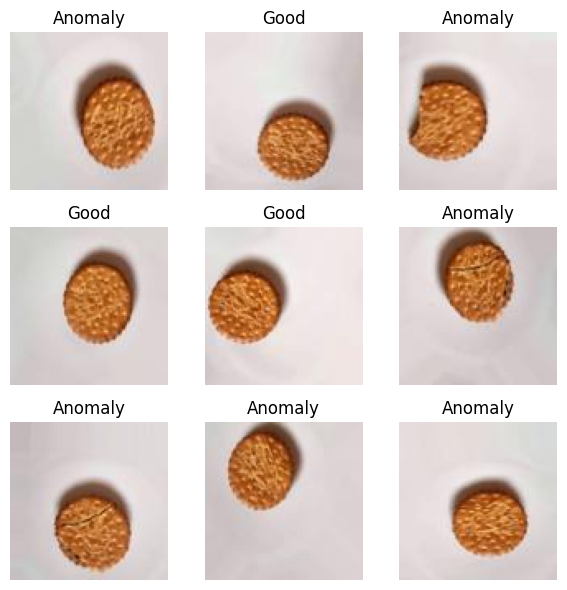

In [2]:
def plot_images_from_generator(generator, num_images=8):  
    """  
    This function plots a series of images returned by an ImageDataGenerator.  
  
    Parameters:  
    - generator: The ImageDataGenerator instance to plot images from.  
    - num_images: Number of images to display.  
    """  
      
    # Get a batch of images  
    imgs, labels = next(generator)  # 'next' retrieves the next batch  
      
    # Determine the grid size needed  
    nrows = int(num_images ** 0.5)  
    ncols = int(np.ceil(num_images / nrows))  
      
    # Set up matplotlib fig, and size it to fit `num_images` images  
    plt.figure(figsize=(6, 6))  
    for i in range(num_images):  
        plt.subplot(nrows, ncols, i + 1)  
        # Rescale images to display them correctly  
        img = imgs[i] * 255  # Assuming the generator rescales images by 1/255  
        plt.imshow(img.astype(np.uint8))  
          
        # Adjusting label display for possibly one-hot encoded labels  
        if generator.class_mode == 'categorical':  
            # For one-hot encoded labels, find the index of the max value  
            label = np.argmax(labels[i])  
            if label == 0:  
                plt.title('Anomaly')  
            else:  
                plt.title('Good')  
        else:  
            # For binary labels  
            if labels[i] == 1:  
                plt.title('Good')  
            else:  
                plt.title('Anomaly')  
  
        plt.axis('off')  
    plt.tight_layout()  
    plt.show()  
  
# Assumes 'train_generator' is already instantiated as per the previous discussion  
plot_images_from_generator(train_generator, num_images=9)  

In [3]:
history = model.fit(  
    train_generator,  
    steps_per_epoch=steps_per_epoch,  
    validation_data=validation_generator,  
    validation_steps=validation_steps,  
    epochs=10  # Number of epochs  
)  

Epoch 1/10
39/39 [==============================] - 8s 161ms/step - loss: 0.7506 - accuracy: 0.7030 - val_loss: 0.8406 - val_accuracy: 0.7161
Epoch 2/10
39/39 [==============================] - 6s 164ms/step - loss: 0.2235 - accuracy: 0.9021 - val_loss: 0.8408 - val_accuracy: 0.7290
Epoch 3/10
39/39 [==============================] - 7s 174ms/step - loss: 0.1460 - accuracy: 0.9358 - val_loss: 0.6574 - val_accuracy: 0.7742
Epoch 4/10
39/39 [==============================] - 7s 175ms/step - loss: 0.0737 - accuracy: 0.9727 - val_loss: 0.5388 - val_accuracy: 0.7806
Epoch 5/10
39/39 [==============================] - 7s 182ms/step - loss: 0.0733 - accuracy: 0.9743 - val_loss: 0.3820 - val_accuracy: 0.8581
Epoch 6/10
39/39 [==============================] - 7s 187ms/step - loss: 0.0296 - accuracy: 0.9920 - val_loss: 0.3748 - val_accuracy: 0.8710
Epoch 7/10
39/39 [==============================] - 8s 196ms/step - loss: 0.0410 - accuracy: 0.9872 - val_loss: 0.1919 - val_accuracy: 0.9226
Epoch 

1/1 [==============================] - 0s 486ms/step


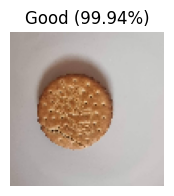

1/1 [==============================] - 0s 46ms/step


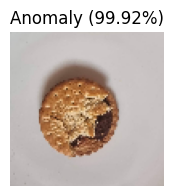

1/1 [==============================] - 0s 47ms/step


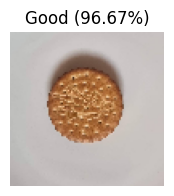

In [4]:
def predict_and_display_image(image_path, model, classes=['Anomaly', 'Good']):    
    # Loading and preprocessing image    
    img = image.load_img(image_path, target_size=(img_width, img_height))    
    img_array = image.img_to_array(img)    
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch    
    img_array /= 255.0  # Rescale image values to [0, 1]    
    
    # Make prediction    
    predictions = model.predict(img_array)    
    predicted_class_index = np.argmax(predictions, axis=1)[0]  # Get index of the predicted class  
    prediction_score = predictions[0][predicted_class_index]  # Get the prediction score  
    
    # Determine the class based on the predicted index  
    class_prediction = classes[predicted_class_index]    
    score = prediction_score * 100  
  
    plt.figure(figsize=(2, 2))    
    
    # Displaying the image    
    plt.imshow(img)    
    plt.axis('off')  # Don't show axes for images    
    plt.title(f'{class_prediction} ({score:.2f}%)')    
    plt.show()    
  
predict_and_display_image("test/anomaly.jpg", model)  
predict_and_display_image("dataset/test/anomaly/anomaly.20240414_174945.jpg.4rbbj34g.ingestion-848d69cd95-lzk2f.jpg", model)  
predict_and_display_image("test/good.jpg", model)  


In [5]:
test_loss, test_accuracy = model.evaluate(test_generator)  
print(f'Test accuracy: {test_accuracy*100:.2f}%')

1/1 [==============================] - 0s 167ms/step - loss: 0.2102 - accuracy: 0.9333
Test accuracy: 93.33%


In [6]:
from sklearn.metrics import confusion_matrix  
import numpy as np  
  
# Assuming test_generator is properly set up to return the true labels  
predictions = model.predict(test_generator)  
predicted_classes = np.argmax(predictions, axis=1)  
  
# Retrieve the true labels  
true_classes = test_generator.classes  
class_labels = list(test_generator.class_indices.keys())  
  
# Compute the confusion matrix  
cm = confusion_matrix(true_classes, predicted_classes)  
  
# Calculate accuracy per class  
accuracies = cm.diagonal() / cm.sum(axis=1)  
for label, accuracy in zip(class_labels, accuracies):  
    print(f'Accuracy for class {label}: {accuracy*100:.2f}%')  

1/1 [==============================] - 0s 485ms/step
Accuracy for class anomaly: 50.00%
Accuracy for class good: 90.91%


In [7]:
model_save_path = "output/saved_model"  
tf.saved_model.save(model, model_save_path)

model.save('output/model.h5')

# Load the saved model  
saved_model = tf.keras.models.load_model('output/model.h5')  
  
# Convert the model to TensorFlow Lite format  
converter = tf.lite.TFLiteConverter.from_keras_model(saved_model)  
tflite_model = converter.convert()
  
# Save the converted model to a .tflite file  
with open('output/model.tflite', 'wb') as f_out:  
    f_out.write(tflite_model)  

INFO:tensorflow:Assets written to: output/saved_model/assets


INFO:tensorflow:Assets written to: output/saved_model/assets
/Users/m/dev/6be709c0/oc-ai-engineer/OC/P9/v2-cnn-classifier-cookies/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /var/folders/x_/0z24g8110_n09vlvhxmrh0_w0000gp/T/tmp1woqhfq6/assets


INFO:tensorflow:Assets written to: /var/folders/x_/0z24g8110_n09vlvhxmrh0_w0000gp/T/tmp1woqhfq6/assets
2024-04-14 19:27:28.984558: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-14 19:27:28.984592: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-14 19:27:28.985144: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/x_/0z24g8110_n09vlvhxmrh0_w0000gp/T/tmp1woqhfq6
2024-04-14 19:27:28.998751: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-14 19:27:28.998800: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/x_/0z24g8110_n09vlvhxmrh0_w0000gp/T/tmp1woqhfq6
2024-04-14 19:27:29.020098: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-04-14 19:27:29.030358: I tensorflow/cc/saved_model/load